In [68]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from keras import regularizers
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import os
from datetime import datetime
from sklearn.metrics import roc_auc_score as auc 

In [2]:
df = pd.read_csv('aml.csv', sep=',', encoding = "ISO-8859-1")

In [3]:
df.head()

,Unnamed: 0,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,countryOrig,ownerOrig,countryDest
0,1,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0,Mexico,Thailand,Denmark
1,2,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0,Fiji,Kuwait,Norway
2,3,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0,Ecuador,Ecuador,Norway
3,4,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0,Syria,Syria,Denmark
4,5,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0,Sri Lanka,Japan,Norway


In [4]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [5]:
df.isnull().values.any()

False

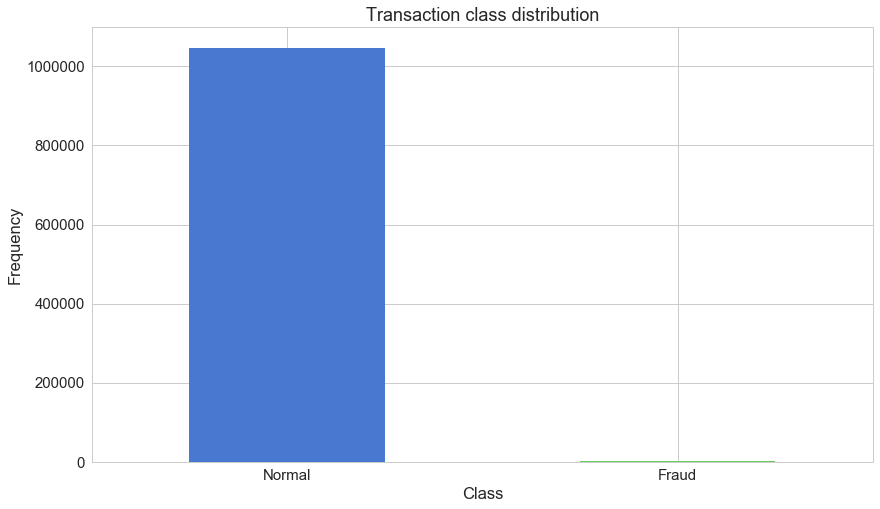

In [6]:
count_classes = pd.value_counts(df['isFraud'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [7]:
frauds = df[df.isFraud == 1]
normal = df[df.isFraud == 0]

In [8]:
frauds.shape[0]/normal.shape[0]

0.0010902845337124188

In [9]:
df=df.drop(['Unnamed: 0'], axis=1)

In [10]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,countryOrig,ownerOrig,countryDest
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0,Mexico,Thailand,Denmark
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0,Fiji,Kuwait,Norway
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0,Ecuador,Ecuador,Norway
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0,Syria,Syria,Denmark
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0,Sri Lanka,Japan,Norway


In [11]:
frauds.amount.describe()

count       1142.000
mean     1192628.932
std      2030598.964
min          119.000
25%        86070.170
50%       353179.450
75%      1248759.002
max     10000000.000
Name: amount, dtype: float64

In [12]:
normal.amount.describe()

count   1047433.000
mean     157539.663
std      254188.285
min           0.100
25%       12134.870
50%       76214.970
75%      213492.750
max     6419835.270
Name: amount, dtype: float64

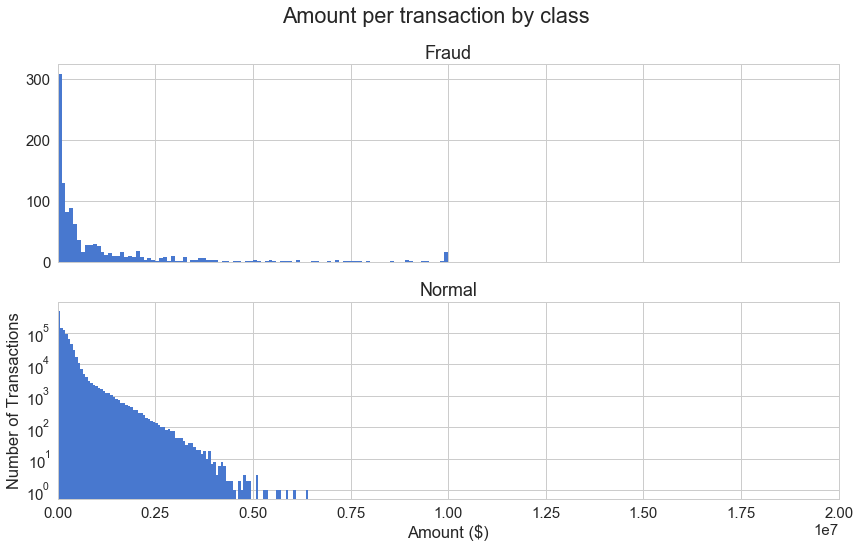

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 100

ax1.hist(frauds.amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000000))
plt.yscale('log')
plt.show();

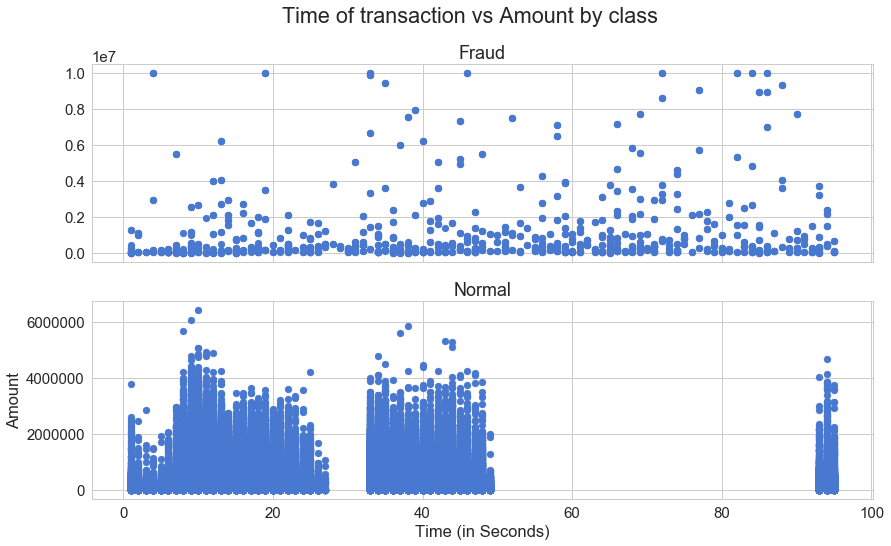

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.step, frauds.amount)
ax1.set_title('Fraud')

ax2.scatter(normal.step, normal.amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [15]:
df= df.drop(['step'], axis=1)

In [16]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,countryOrig,ownerOrig,countryDest
0,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0,Mexico,Thailand,Denmark
1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0,Fiji,Kuwait,Norway
2,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0,Ecuador,Ecuador,Norway
3,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0,Syria,Syria,Denmark
4,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0,Sri Lanka,Japan,Norway


In [17]:
df.shape

(1048575, 13)

# Initial pre-processing

In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
enc = OneHotEncoder(handle_unknown='ignore')

In [20]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,countryOrig,ownerOrig,countryDest
0,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0,Mexico,Thailand,Denmark
1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0,Fiji,Kuwait,Norway
2,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0,Ecuador,Ecuador,Norway
3,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0,Syria,Syria,Denmark
4,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0,Sri Lanka,Japan,Norway


In [21]:
df=df.set_index([df['nameOrig'],df['nameDest']])

In [22]:
cat_type = pd.get_dummies(df['type'])
cat_country_origin = pd.get_dummies(df['countryOrig'])
cat_country_dest = pd.get_dummies(df['countryDest'])
cat_owner_orig = pd.get_dummies(df['ownerOrig'])

In [23]:
remove = ['type','countryOrig','ownerOrig','countryDest']

In [24]:
df = df.drop(remove, axis=1)

In [25]:
df.head()

,,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
nameOrig,nameDest,,,,,,,,,
C1231006815,M1979787155,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0
C1666544295,M2044282225,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0
C1305486145,C553264065,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0
C840083671,C38997010,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0
C2048537720,M1230701703,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0


In [26]:
df.head()

,,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
nameOrig,nameDest,,,,,,,,,
C1231006815,M1979787155,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0
C1666544295,M2044282225,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0
C1305486145,C553264065,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0
C840083671,C38997010,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0
C2048537720,M1230701703,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0


In [27]:
df2=pd.concat([df,cat_type, cat_country_dest,cat_country_origin,cat_owner_orig],axis=1)

In [28]:
df2.CASH_IN.unique()

array([0, 1], dtype=uint64)

In [29]:
df2.head()

,,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,...,Sweden,Syria,São Tomé-et-Príncipe,Taiwan,Tanzania,Thailand,Turkey,USA,Vietnam,Yemen
nameOrig,nameDest,,,,,,,,,,,,,,,,,,,,,
C1231006815,M1979787155,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0,0,...,0,0,0,0,0,1,0,0,0,0
C1666544295,M2044282225,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1305486145,C553264065,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
C840083671,C38997010,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0,0,...,0,1,0,0,0,0,0,0,0,0
C2048537720,M1230701703,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df2 = df2.set_index(['nameOrig','nameDest'])

In [31]:
df2.head()

,,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,...,Sweden,Syria,São Tomé-et-Príncipe,Taiwan,Tanzania,Thailand,Turkey,USA,Vietnam,Yemen
nameOrig,nameDest,,,,,,,,,,,,,,,,,,,,,
C1231006815,M1979787155,9839.640,170136.000,160296.360,0.000,0.000,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
C1666544295,M2044282225,1864.280,21249.000,19384.720,0.000,0.000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1305486145,C553264065,181.000,181.000,0.000,0.000,0.000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C840083671,C38997010,181.000,181.000,0.000,21182.000,0.000,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
C2048537720,M1230701703,11668.140,41554.000,29885.860,0.000,0.000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
from sklearn.preprocessing import MinMaxScaler

In [33]:
scaler = MinMaxScaler()

In [34]:
df2[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']] = scaler.fit_transform(df2[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']])

In [35]:
israud = df2['isFraud']

In [36]:
df2=df2.drop(['isFraud'],axis=1)

In [37]:
df2.head()

,,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,...,Sweden,Syria,São Tomé-et-Príncipe,Taiwan,Tanzania,Thailand,Turkey,USA,Vietnam,Yemen
nameOrig,nameDest,,,,,,,,,,,,,,,,,,,,,
C1231006815,M1979787155,0.001,0.004,0.004,0.000,0.000,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
C1666544295,M2044282225,0.000,0.001,0.000,0.000,0.000,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
C1305486145,C553264065,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C840083671,C38997010,0.000,0.000,0.000,0.001,0.000,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
C2048537720,M1230701703,0.001,0.001,0.001,0.000,0.000,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# PCA pre-processing

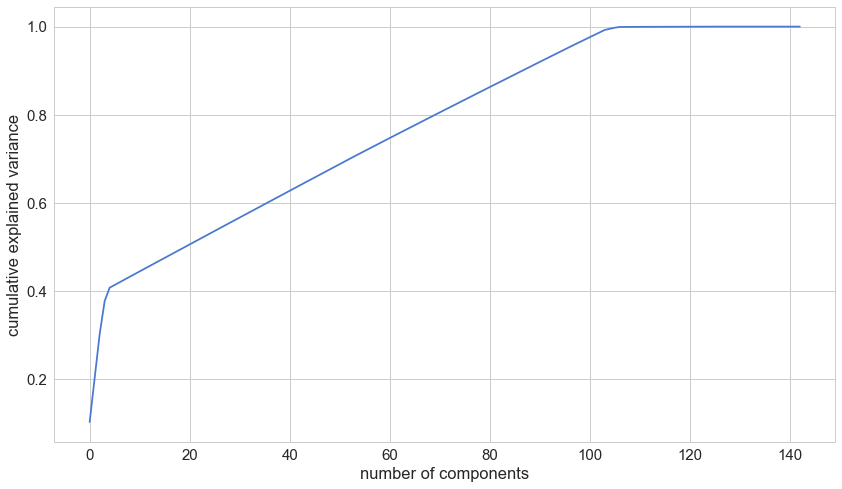

In [38]:
from sklearn.decomposition import PCA
pca = PCA().fit(df2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [39]:


pca = PCA(n_components=100)

principalComponents = pca.fit_transform(df2)



In [40]:
principalComponents.shape

(1048575, 100)

In [41]:
fraud = df.isFraud

In [42]:
fraud=fraud.reset_index()

In [43]:
fraud=fraud.drop(['nameOrig','nameDest'], axis=1)

In [44]:
fraud.head()

,isFraud
0,0
1,0
2,1
3,1
4,0


In [45]:
principalDf = pd.DataFrame(data = principalComponents)

In [46]:
df2['isFraud'] = israud

In [47]:
principalDf['isFraud'] = fraud

In [48]:
principalDf.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,isFraud
0,-0.685,0.695,-0.459,-0.340,-0.081,0.002,-0.004,-0.002,-0.013,-0.018,...,0.004,-0.058,-0.002,0.005,-0.009,-0.031,-0.022,-0.005,-0.013,0
1,-0.640,-0.721,-0.481,-0.344,-0.080,-0.034,0.004,-0.010,-0.042,-0.045,...,-0.015,-0.006,0.004,-0.011,-0.012,-0.017,-0.004,-0.007,0.000,0
2,0.039,-0.702,-0.419,0.164,1.043,0.000,-0.000,0.001,-0.000,-0.000,...,0.001,-0.001,-0.000,-0.000,0.000,-0.000,0.001,0.002,-0.000,1
3,0.720,0.736,-0.314,-0.283,-0.077,0.000,0.000,-0.000,-0.000,-0.000,...,0.001,0.001,0.001,0.001,0.001,0.001,0.002,0.001,0.001,1
4,-0.640,-0.721,-0.481,-0.345,-0.082,-0.010,-0.009,-0.004,-0.004,0.008,...,-0.085,-0.093,0.006,-0.004,-0.012,-0.019,-0.029,-0.039,-0.029,0


## Ready for training

In [56]:
df2['isFraud'] = df['isFraud']

In [58]:
df2.head()

,,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,...,Syria,São Tomé-et-Príncipe,Taiwan,Tanzania,Thailand,Turkey,USA,Vietnam,Yemen,isFraud
nameOrig,nameDest,,,,,,,,,,,,,,,,,,,,,
C1231006815,M1979787155,0.001,0.004,0.004,0.000,0.000,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
C1666544295,M2044282225,0.000,0.001,0.000,0.000,0.000,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
C1305486145,C553264065,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
C840083671,C38997010,0.000,0.000,0.000,0.001,0.000,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
C2048537720,M1230701703,0.001,0.001,0.001,0.000,0.000,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [71]:
X_train, X_test = train_test_split(principalDf, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.isFraud == 0]


In [72]:
X_train.isFraud.unique()

array([0], dtype=int64)

In [73]:
X_train = X_train.drop(['isFraud'], axis=1)

In [74]:
X_train.shape

(837942, 100)

In [75]:
y_test = X_test['isFraud']

In [76]:
y_test.unique()

array([0, 1], dtype=int64)

In [77]:
X_test = X_test.drop(['isFraud'], axis=1)

In [78]:
X_test.shape

(209715, 100)

In [79]:
X_train.shape

(837942, 100)

In [80]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
781974,-0.003,0.712,-0.397,0.169,1.047,-0.008,0.024,0.005,-0.040,-0.064,...,0.005,-0.018,-0.042,0.012,0.002,-0.014,-0.018,0.012,-0.025,-0.008
937737,-0.030,0.709,-0.405,0.945,-0.171,-0.025,-0.010,0.013,-0.020,-0.018,...,-0.078,-0.030,-0.059,0.012,-0.018,-0.003,-0.017,-0.018,-0.017,-0.028
907828,-0.030,0.710,-0.404,0.901,-0.156,-0.023,-0.014,0.009,0.004,-0.030,...,-0.097,-0.052,-0.084,-0.041,-0.040,-0.033,-0.066,-0.026,-0.006,-0.024
784628,-0.788,-0.035,0.748,-0.331,-0.077,-0.081,-0.641,-0.605,0.370,0.080,...,-0.029,-0.016,-0.044,-0.009,-0.008,-0.036,-0.018,-0.049,-0.029,-0.016
662460,0.618,0.008,0.893,-0.272,-0.072,0.003,0.033,0.010,-0.031,-0.029,...,0.015,-0.009,-0.036,0.020,0.000,-0.004,-0.027,-0.012,-0.011,0.000


In [81]:
X_train = X_train.values
X_test = X_test.values

In [82]:
X_train

array([[ 6.16341684e-01,  7.10023452e-03,  8.92555573e-01, ...,
         7.46598724e-04, -1.58829064e-02, -1.23116297e-02],
       [-7.87924547e-01, -3.38073547e-02,  7.46881150e-01, ...,
        -1.84218408e-02, -1.00451517e-02, -2.57161957e-02],
       [ 7.20930690e-01,  7.35623680e-01, -3.13506868e-01, ...,
        -3.01487849e-02, -4.16010641e-02, -3.23211725e-02],
       ...,
       [ 7.64396286e-01, -6.78456807e-01, -3.35982670e-01, ...,
        -7.95911751e-02, -6.52043807e-02, -3.56140164e-02],
       [ 6.16209303e-01,  5.81501694e-03,  8.92592337e-01, ...,
        -5.23680548e-02, -3.53227530e-02, -4.41362159e-02],
       [-7.88137588e-01, -3.52737471e-02,  7.47714251e-01, ...,
         6.32856572e-03, -3.29946726e-02, -8.80575710e-03]])

In [83]:
input_dim

NameError: name 'input_dim' is not defined

## Set up the model

In [84]:
input_dim = X_train.shape[1]
encoding_dim = 100

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="relu",activity_regularizer=regularizers.l1(0.08))(input_layer)
 
                
encoder = Dense(int(encoding_dim / 2), activation="relu", activity_regularizer=regularizers.l1(0.08))(encoder)

decoder = Dense(int(encoding_dim / 2), activation='relu',activity_regularizer=regularizers.l1(0.08))(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [123]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_21 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_22 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_23 (Dense)             (None, 100)               5100      
Total params: 22,800
Trainable params: 22,800
Non-trainable params: 0
_________________________________________________________________


In [112]:
adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

## Train

In [113]:
nb_epoch = 10
batch_size = 50

autoencoder.compile(optimizer=adam, 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="mode35l.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 837942 samples, validate on 209715 samples
Epoch 1/10
837942/837942 [==============================] - 35s 42us/step - loss: 4.7642 - acc: 0.1160 - val_loss: 1.2774 - val_acc: 0.1159
Epoch 2/10
837942/837942 [==============================] - 36s 43us/step - loss: 0.8358 - acc: 0.0860 - val_loss: 0.5292 - val_acc: 0.0371
Epoch 3/10
837942/837942 [==============================] - 38s 45us/step - loss: 0.3639 - acc: 0.0370 - val_loss: 0.2339 - val_acc: 0.0371
Epoch 4/10
837942/837942 [==============================] - 38s 46us/step - loss: 0.1485 - acc: 0.0372 - val_loss: 0.0842 - val_acc: 0.0371
Epoch 5/10
837942/837942 [==============================] - 40s 48us/step - loss: 0.0592 - acc: 0.0381 - val_loss: 0.0439 - val_acc: 0.0371
Epoch 6/10
837942/837942 [==============================] - 40s 48us/step - loss: 0.0384 - acc: 0.0388 - val_loss: 0.0350 - val_acc: 0.0371
Epoch 7/10
837942/837942 [==============================] - 40s 48us/step - loss: 0.0338 - acc: 0.0370 - val

In [114]:
autoencoder = load_model('mode35l.h5')

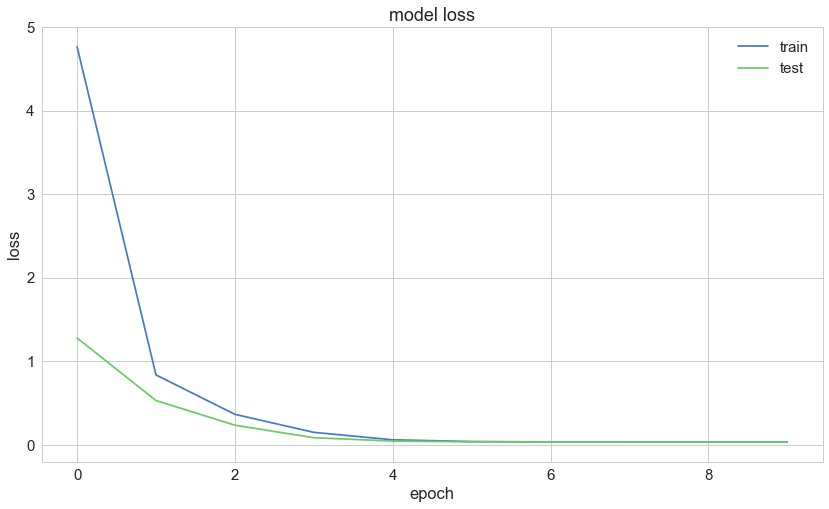

In [115]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [116]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [117]:
predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

error_df.describe()

,reconstruction_error,true_class
count,209715.000,209715.000
mean,0.033,0.001
std,0.003,0.033
min,0.012,0.000
25%,0.032,0.000
50%,0.033,0.000
75%,0.035,0.000
max,0.039,1.000


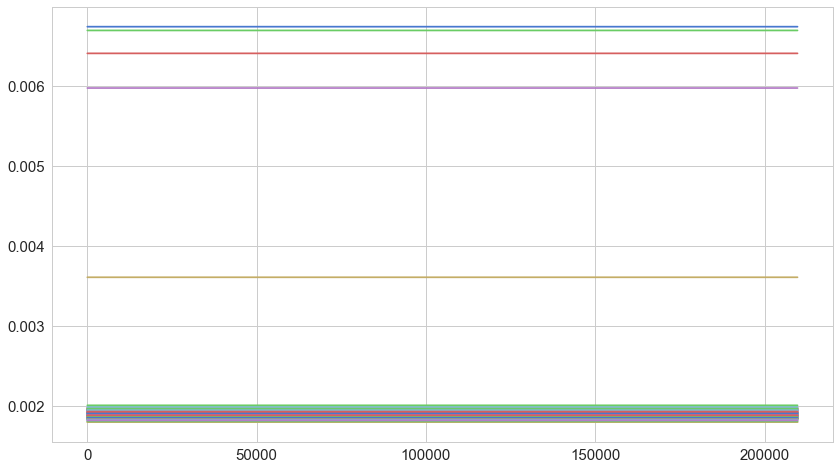

In [125]:
plt.plot(predictions)

In [118]:
error_df.true_class.value_counts()

0    209491
1       224
Name: true_class, dtype: int64

In [119]:
plt.plot(fpr)

NameError: name 'fpr' is not defined

In [120]:
roc_auc

NameError: name 'roc_auc' is not defined

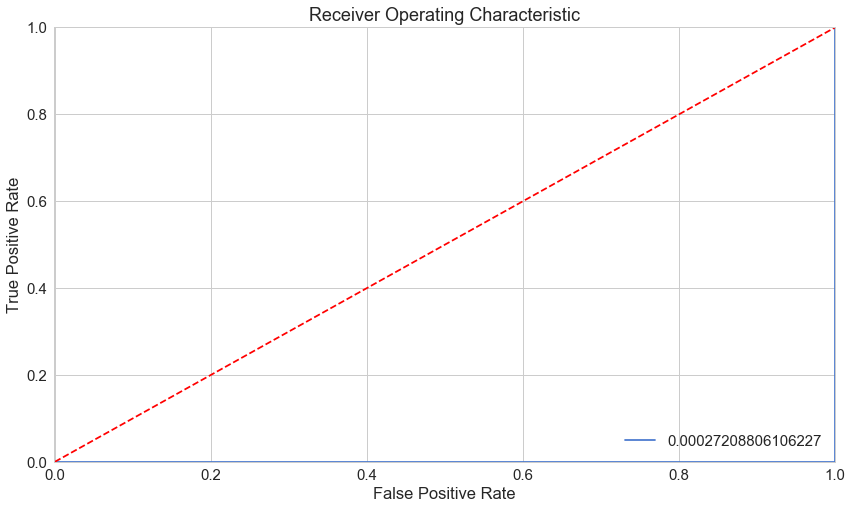

In [121]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label=roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [86]:
threshold = 0.02

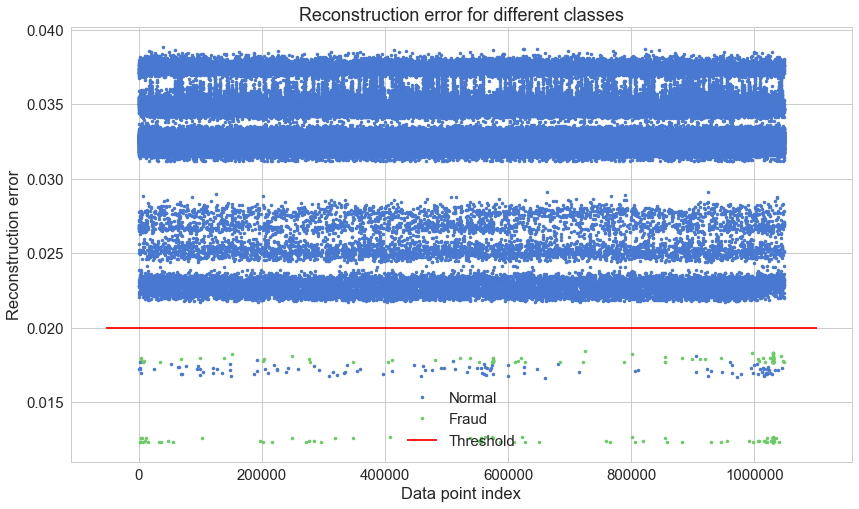

In [87]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= ("Fraud" if name == 1 else "Normal"))
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

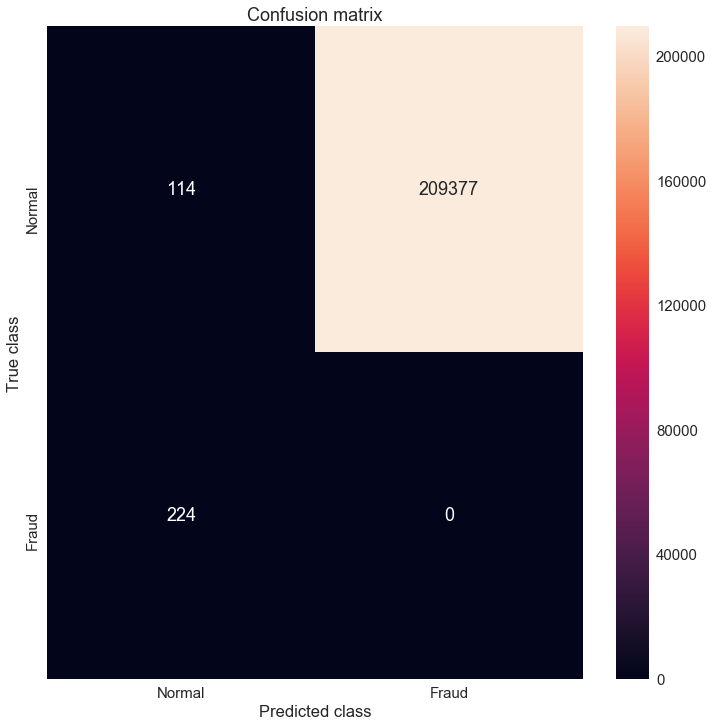

In [88]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()